In [1]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
img_width, img_height = 224, 224
train_data_dir = 'train_small'
validation_data_dir = 'test_small'

# 1. MobileNet Model with small data

In [3]:
mobile = applications.MobileNet(weights = 'imagenet',
                               include_top = False,
                               input_shape = (img_width, img_height, 3))
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [4]:
for layers in mobile.layers:
    layers.trainable = False

In [5]:
x = mobile.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(1, activation = 'sigmoid')(x)

In [6]:
mobile_model = Model(inputs = mobile.input, outputs = predictions)

In [7]:
mobile_model.compile(loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 30)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size = (img_height, img_width),
                                                    batch_size = 32,
                                                    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size = (img_height, 
                                                                       img_width),
                                                        class_mode = 'binary')

Found 2003 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.


In [10]:
checkpoint = ModelCheckpoint('bike_car_mobilenet.h5',
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             save_weight_only = False,
                             mode = 'auto',
                             save_freq = 1)
early = EarlyStopping(monitor = 'val_loss',
                      min_delta = 0.001,
                      verbose = 1,
                      mode = 'auto')

In [11]:
import time

t1 = time.time()
mobile_his = mobile_model.fit(train_generator,
                          validation_data = validation_generator,
                          batch_size = 32,
                          epochs = 150,
                          callbacks = [checkpoint, early])
t2 = time.time()

print('MobileNet model training took: {:.2f} minutes.'.format((t2 - t1)/ 60))

Epoch 1/150
63/63 [==============================] - ETA: 0s - loss: 1.9845 - accuracy: 0.9371WARNING:tensorflow:Can save best model only with val_loss available, skipping.


/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


63/63 [==============================] - 79s 1s/step - loss: 1.9845 - accuracy: 0.9371 - val_loss: 0.0601 - val_accuracy: 0.9975
MobileNet model training took: 1.33 minutes.


In [13]:
df_mobile = pd.DataFrame(mobile_his.history)
df_mobile

,loss,accuracy,val_loss,val_accuracy
0,1.984479,0.937094,0.060122,0.997502


- MobileNet bị underfitting đối với lượng dữ liệu và chiến lược huấn luyện này.

# 2. InceptionV3 Model with small data

In [15]:
img_width_new, img_height_new = 299, 299

In [16]:
inception = applications.InceptionV3(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (img_width_new, img_height_new, 3))
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
for layer in inception.layers:
    layer.trainable = False

In [18]:
x = inception.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(1, activation = 'sigmoid')(x)

In [19]:
inception_model = Model(inputs = inception.input, outputs = predictions)

In [20]:
inception_model.compile(loss = 'binary_crossentropy',
                     optimizer = 'adam',
                     metrics =['accuracy'])

In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 30)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [22]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height_new, img_width_new),
                                                    batch_size = 32,
                                                    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size = (img_height_new, img_width_new),
                                                        class_mode = 'binary')

Found 2003 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.


In [23]:
checkpoint = ModelCheckpoint('bike_car_inception.h5',
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             save_weights_only = False,
                             mode = 'auto',
                             save_freq = 1)

early = EarlyStopping(monitor = 'val_loss',
                      min_delta = 0.001,
                      patience = 5,
                      verbose = 1,
                      mode = 'auto')

In [24]:
t1 = time.time()

his1 = inception_model.fit(train_generator,
                        validation_data = validation_generator,
                        batch_size = 32,
                        epochs = 100,
                        callbacks = [checkpoint, early])
t2 = time.time()

print('InceptionV3 training took {:.2f} minutes.'.format((t2 - t1)/ 60))

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 2.2692 - accuracy: 0.9536WARNING:tensorflow:Can save best model only with val_loss available, skipping.


/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


63/63 [==============================] - 173s 3s/step - loss: 2.2692 - accuracy: 0.9536 - val_loss: 0.1811 - val_accuracy: 0.9969
Epoch 2/100
63/63 [==============================] - 188s 3s/step - loss: 0.5970 - accuracy: 0.9870 - val_loss: 0.2552 - val_accuracy: 0.9900
Epoch 3/100
35/63 [===============>..............] - ETA: 51s - loss: 0.5553 - accuracy: 0.9819WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 194s 3s/step - loss: 0.5979 - accuracy: 0.9840 - val_loss: 0.0249 - val_accuracy: 0.9975
Epoch 4/100
63/63 [==============================] - 193s 3s/step - loss: 0.0882 - accuracy: 0.9930 - val_loss: 0.0232 - val_accuracy: 0.9988
Epoch 5/100
 8/63 [==>...........................] - ETA: 1:45 - loss: 0.1045 - accuracy: 0.9922WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 198s 3s/step - loss: 0.1062 - accuracy: 0.9945 - val_loss: 0.0583 - val_accuracy: 0.9969
Epoch 6/100
44/63 [===================>..........] - ETA: 36s - loss: 0.2678 - accuracy: 0.9864WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 200s 3s/step - loss: 0.2375 - accuracy: 0.9880 - val_loss: 0.0603 - val_accuracy: 0.9956
Epoch 7/100
63/63 [==============================] - 201s 3s/step - loss: 0.0810 - accuracy: 0.9950 - val_loss: 0.0091 - val_accuracy: 0.9988
Epoch 8/100
16/63 [======>.......................] - ETA: 1:31 - loss: 0.0221 - accuracy: 0.9980WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 202s 3s/step - loss: 0.1306 - accuracy: 0.9960 - val_loss: 0.0073 - val_accuracy: 0.9981
Epoch 9/100
 3/63 [>.............................] - ETA: 1:59 - loss: 5.7372e-06 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 204s 3s/step - loss: 0.0600 - accuracy: 0.9930 - val_loss: 0.0500 - val_accuracy: 0.9969
Epoch 10/100
39/63 [=================>............] - ETA: 47s - loss: 0.1239 - accuracy: 0.9936WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 204s 3s/step - loss: 0.1181 - accuracy: 0.9950 - val_loss: 0.2937 - val_accuracy: 0.9894
Epoch 11/100
63/63 [==============================] - 205s 3s/step - loss: 0.0813 - accuracy: 0.9935 - val_loss: 0.2766 - val_accuracy: 0.9881
Epoch 12/100
11/63 [====>.........................] - ETA: 1:43 - loss: 4.2883e-04 - accuracy: 1.0000WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 204s 3s/step - loss: 0.0551 - accuracy: 0.9945 - val_loss: 0.0230 - val_accuracy: 0.9963
Epoch 13/100
47/63 [=====================>........] - ETA: 31s - loss: 0.1387 - accuracy: 0.9899WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 205s 3s/step - loss: 0.1289 - accuracy: 0.9915 - val_loss: 0.0138 - val_accuracy: 0.9975
Epoch 00013: early stopping
InceptionV3 training took 42.86 minutes.


In [26]:
df_inception = pd.DataFrame(his1.history)
df_inception.tail()

,loss,accuracy,val_loss,val_accuracy
8,0.059960,0.993010,0.049999,0.996877
9,0.118082,0.995008,0.293744,0.989382
10,0.081255,0.993510,0.276638,0.988132
11,0.055056,0.994508,0.022983,0.996252
12,0.128914,0.991513,0.013804,0.997502


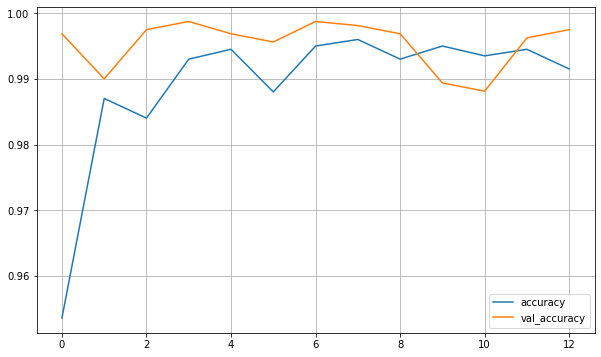

In [55]:
df_inception.loc[:, ['accuracy', 'val_accuracy']].plot(figsize = (10, 6))
plt.grid(True);

- InceptionV3 cho kết quả tốt hơn với thời gian huấn luyện không khác biệt nhiều so với mô hình CNN ở câu 3.

# 3. VGG16 with small data

In [27]:
vgg16 = applications.VGG16(weights = 'imagenet',
                               include_top = False,
                               input_shape = (img_width, img_height, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
for layer in vgg16.layers:
    layer.trainable = False

In [29]:
x = vgg16.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(1, activation = 'sigmoid')(x)

In [30]:
vgg16_model = Model(inputs = vgg16.input, outputs = predictions)

In [31]:
vgg16_model.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [32]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 0.3)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [33]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height, img_width),
                                                    batch_size = 32,
                                                    class_mode = 'binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size = (img_height, 
                                                                       img_width),
                                                        batch_size = 32,
                                                        class_mode = 'binary')

Found 2003 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.


In [34]:
checkpoint = ModelCheckpoint('bike_car_vgg16.h5',
                             monitor = 'val_loss',
                             save_best_only = True,
                             save_weights_only = False,
                             mode = 'auto',
                             save_freq = 1)

early = EarlyStopping(monitor = 'val_loss',
                      min_delta = 0.001,
                      patience = 5,
                      mode = 'auto')

In [35]:
t1 = time.time()
vgg16_his = vgg16_model.fit(train_generator,
                        validation_data = validation_generator,
                        batch_size = 32,
                        epochs = 100,
                        callbacks = [checkpoint, early])
t2 = time.time()
print('VGG16 training took {:.2f} minutes.'.format((t2 - t1)/ 60))

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.9231WARNING:tensorflow:Can save best model only with val_loss available, skipping.


/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


63/63 [==============================] - 343s 5s/step - loss: 0.3743 - accuracy: 0.9231 - val_loss: 0.0468 - val_accuracy: 0.9856
Epoch 2/100
63/63 [==============================] - 398s 6s/step - loss: 0.0525 - accuracy: 0.9810 - val_loss: 0.0946 - val_accuracy: 0.9744
Epoch 3/100
35/63 [===============>..............] - ETA: 1:38 - loss: 0.0634 - accuracy: 0.9810WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 409s 7s/step - loss: 0.0510 - accuracy: 0.9830 - val_loss: 0.0356 - val_accuracy: 0.9863
Epoch 4/100
63/63 [==============================] - 424s 7s/step - loss: 0.0313 - accuracy: 0.9895 - val_loss: 0.0301 - val_accuracy: 0.9906
Epoch 5/100
 7/63 [==>...........................] - ETA: 3:12 - loss: 0.0247 - accuracy: 0.9911WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 418s 7s/step - loss: 0.0268 - accuracy: 0.9910 - val_loss: 0.0224 - val_accuracy: 0.9919
Epoch 6/100
43/63 [===================>..........] - ETA: 1:13 - loss: 0.0135 - accuracy: 0.9963WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 406s 6s/step - loss: 0.0130 - accuracy: 0.9960 - val_loss: 0.0465 - val_accuracy: 0.9831
Epoch 7/100
63/63 [==============================] - 425s 7s/step - loss: 0.0295 - accuracy: 0.9900 - val_loss: 0.0497 - val_accuracy: 0.9850
Epoch 8/100
15/63 [======>.......................] - ETA: 2:59 - loss: 0.0140 - accuracy: 0.9958WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 405s 6s/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0984 - val_accuracy: 0.9725
Epoch 9/100
51/63 [=======================>......] - ETA: 43s - loss: 0.0427 - accuracy: 0.9858WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 403s 6s/step - loss: 0.0358 - accuracy: 0.9880 - val_loss: 0.0380 - val_accuracy: 0.9869
Epoch 10/100
63/63 [==============================] - 413s 7s/step - loss: 0.0343 - accuracy: 0.9900 - val_loss: 0.0280 - val_accuracy: 0.9913
VGG16 training took 67.41 minutes.


In [36]:
df_vgg16 = pd.DataFrame(vgg16_his.history)
df_vgg16.tail()

,loss,accuracy,val_loss,val_accuracy
5,0.013016,0.996006,0.046481,0.983136
6,0.029497,0.990015,0.049694,0.985009
7,0.012396,0.996006,0.098389,0.972517
8,0.035778,0.988018,0.037988,0.986883
9,0.034299,0.990015,0.027975,0.991255


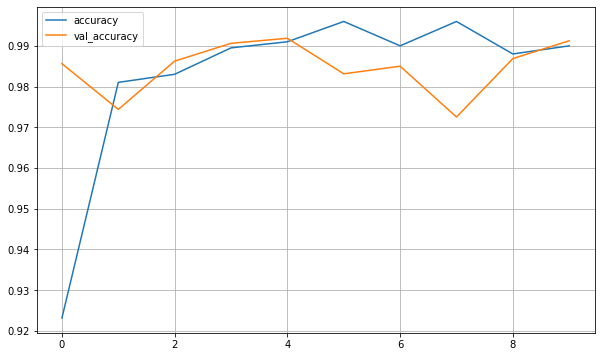

In [54]:
df_vgg16.loc[:, ['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True);

- Hiệu suất của VGG16 tương đương với InceptionV3, tuy nhiên thời gian chạy thuật toán lớn hơn khá nhiều.

# 4. ResNet50 with small data

In [38]:
resnet50 = applications.ResNet50(weights = 'imagenet',
                                 include_top = False,
                                 input_shape = (img_width, img_height, 3))
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [40]:
for layer in resnet50.layers:
    layer.trainable = False

In [41]:
x = resnet50.output
x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(1, activation = 'sigmoid')(x)

In [42]:
resnet_model = Model(inputs = resnet50.input, outputs = predictions)

In [43]:
resnet_model.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [44]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest',
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   rotation_range = 0.3)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [45]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height, img_width),
                                                    batch_size = 32,
                                                    class_mode = 'binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size = (img_height, 
                                                                       img_width),
                                                        batch_size = 32,
                                                        class_mode = 'binary')

Found 2003 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.


In [46]:
checkpoint = ModelCheckpoint('bike_car_vgg16.h5',
                             monitor = 'val_loss',
                             save_best_only = True,
                             save_weights_only = False,
                             mode = 'auto',
                             save_freq = 1)

early = EarlyStopping(monitor = 'val_loss',
                      min_delta = 0.001,
                      patience = 5,
                      mode = 'auto')

In [47]:
t1 = time.time()
resnet_his = resnet_model.fit(train_generator,
                        validation_data = validation_generator,
                        batch_size = 32,
                        epochs = 100,
                        callbacks = [checkpoint, early])
t2 = time.time()
print('ResNet50 training took {:.2f} minutes.'.format((t2 - t1)/ 60))

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 2.5861 - accuracy: 0.6730WARNING:tensorflow:Can save best model only with val_loss available, skipping.


/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


63/63 [==============================] - 213s 3s/step - loss: 2.5861 - accuracy: 0.6730 - val_loss: 0.6853 - val_accuracy: 0.6765
Epoch 2/100
63/63 [==============================] - 220s 4s/step - loss: 0.4110 - accuracy: 0.8128 - val_loss: 0.4526 - val_accuracy: 0.8207
Epoch 3/100
35/63 [===============>..............] - ETA: 56s - loss: 0.5249 - accuracy: 0.7805WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 221s 4s/step - loss: 0.4799 - accuracy: 0.7903 - val_loss: 0.5267 - val_accuracy: 0.7658
Epoch 4/100
22/63 [=========>....................] - ETA: 1:24 - loss: 0.4171 - accuracy: 0.8182WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 226s 4s/step - loss: 0.3944 - accuracy: 0.8323 - val_loss: 0.6369 - val_accuracy: 0.7077
Epoch 5/100
 9/63 [===>..........................] - ETA: 1:55 - loss: 0.3844 - accuracy: 0.8229WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 230s 4s/step - loss: 0.3451 - accuracy: 0.8492 - val_loss: 0.4564 - val_accuracy: 0.8082
Epoch 6/100
45/63 [====================>.........] - ETA: 38s - loss: 0.3523 - accuracy: 0.8437WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 231s 4s/step - loss: 0.3692 - accuracy: 0.8412 - val_loss: 0.5119 - val_accuracy: 0.7839
Epoch 7/100
32/63 [==============>...............] - ETA: 1:06 - loss: 0.3312 - accuracy: 0.8595WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 231s 4s/step - loss: 0.3374 - accuracy: 0.8582 - val_loss: 0.3990 - val_accuracy: 0.8420
Epoch 8/100
19/63 [========>.....................] - ETA: 1:34 - loss: 0.3302 - accuracy: 0.8536WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 238s 4s/step - loss: 0.3639 - accuracy: 0.8352 - val_loss: 0.4112 - val_accuracy: 0.8413
Epoch 9/100
 6/63 [=>............................] - ETA: 2:08 - loss: 0.3584 - accuracy: 0.8438WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 231s 4s/step - loss: 0.3440 - accuracy: 0.8532 - val_loss: 0.6085 - val_accuracy: 0.7439
Epoch 10/100
42/63 [===================>..........] - ETA: 44s - loss: 0.3158 - accuracy: 0.8728WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 227s 4s/step - loss: 0.3052 - accuracy: 0.8777 - val_loss: 0.4694 - val_accuracy: 0.8057
Epoch 11/100
29/63 [============>.................] - ETA: 1:09 - loss: 0.2883 - accuracy: 0.8863WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 225s 4s/step - loss: 0.3032 - accuracy: 0.8697 - val_loss: 0.6427 - val_accuracy: 0.7127
Epoch 12/100
16/63 [======>.......................] - ETA: 1:37 - loss: 0.3254 - accuracy: 0.8770WARNING:tensorflow:Can save best model only with val_loss available, skipping.


63/63 [==============================] - 225s 4s/step - loss: 0.3158 - accuracy: 0.8727 - val_loss: 0.4289 - val_accuracy: 0.8114
ResNet50 training took 45.32 minutes.


In [48]:
df_resnet = pd.DataFrame(resnet_his.history)
df_resnet.tail()

,loss,accuracy,val_loss,val_accuracy
7,0.363936,0.835247,0.411166,0.841349
8,0.344011,0.853220,0.608453,0.743910
9,0.305185,0.877683,0.469437,0.805746
10,0.303195,0.869695,0.642653,0.712680
11,0.315766,0.872691,0.428888,0.811368


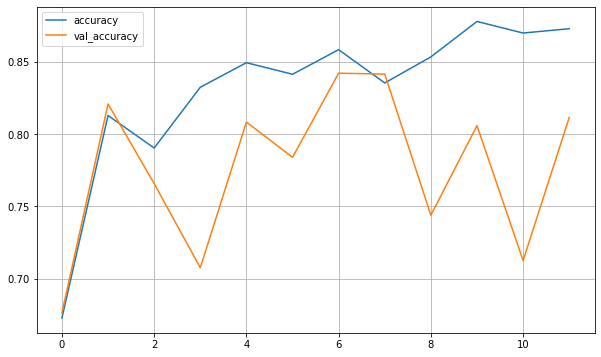

In [53]:
df_resnet.loc[:, ['accuracy', 'val_accuracy']].plot(figsize = (10, 6))
plt.grid(True);

- Mặc dù thời gian huấn luyện tương tự với mô hình CNN ở câu 3 nhưng độ chính xác thấp hơn khá nhiều so với mô hình gốc.

- __Kết luận:__
- Ta sẽ lựa chọn mô hình InceptionV3, huấn luyện với lượng dữ liệu nhỏ và không tháo băng bất kỳ phần nào của mô hình gốc và lưu mô hình này.

In [58]:
from tensorflow.keras.models import load_model

inception_model.save('InceptionV3_pretrained_bike_car.h5')